In [1]:
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import dynamo as dyn
import numpy as np
import pandas as pd
from anndata import AnnData
from sklearn import preprocessing

/home/dap182/anaconda3/envs/kb/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
def plot_X(X, dim1=0, dim2=1, create_figure=False, figsize=(6, 6), **kwargs):
    if create_figure:
        plt.figure(figsize=figsize)
    plt.scatter(X[:, dim1], X[:, dim2], **kwargs)
    
def plot_V(X, V, dim1=0, dim2=1, create_figure=False, figsize=(6, 6), **kwargs):
    if create_figure:
        plt.figure(figsize=figsize)
    plt.quiver(X[:, dim1], X[:, dim2], V[:, dim1], V[:, dim2])
    
def color_set(data,gene):
    gene_idx=np.where(data.var_names==gene)[0][0]
    c=np.squeeze(np.asarray(data.X[:,gene_idx].todense()))
    return c

def color_treatment(adata):
    le=preprocessing.LabelEncoder()
    treatment=adata.obsm['treatment']
    uniq_labels=np.unique(treatment)
    labels=le.fit(uniq_labels)
    classes=le.classes_
    encoded=le.transform(treatment)
    print(le.get_params())
    return encoded,le

def simulation(tr,num_trajectories,init_probs,final_states):
    #using list because trajectories can be different sizes
    traj_list=[]
    for traj in range(num_trajectories):
        #uses init probabilities to find the initial state
        boolean=np.cumsum(p0)<=np.random.uniform()
        state=np.where(boolean==False)[0][0]
        #appends the first state to the traj list
        traj_list.append(np.array([state]))
        while state not in final_states:
            boolean_list=np.cumsum(tr.P[:,state].data)<=np.random.uniform()
            state=int(tr.Idx[state][np.where(boolean_list==False)[0][0]])
            traj_list[traj]=np.append(traj_list[traj],state)

    return traj_list

In [3]:
adata=dyn.read_h5ad('stable/a549_tgfb1_stable_processed.h5ad')
P=np.loadtxt('stable/a549_tgfb1_stable_P.npy')
Idx=np.load('stable/a549_tgfb1_stable_idx.npy',allow_pickle=True)

adata

AnnData object with n_obs × n_vars = 577 × 308 
    obs: 'Clusters', '_X', '_Y', 'batch', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'Size_Factor', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'use_for_dynamo'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'pass_basic_filter', 'use_for_dynamo', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'delta_b', 'delta_r2', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_velocity'
    uns: 'PCs', 'explained_variance_ratio_', 'pp_log'
    obsm: 'X_pca', 'X_umap', 'X_velocity_pca', 'treatment', 'velocity_pca', 'velocity_umap'
    layers: 'M_s', 'M_ss', 'M_u', 'M_us', 'M_uu', 'X_spliced', 'X_unspliced', 'ambiguous', 'matrix', 'spliced', 'unspliced', 'velocity_S'

In [4]:
kmc=dyn.tl.KernelMarkovChain(P=P,Idx=Idx)

X = adata.layers['M_s'][:, adata.var['use_for_velocity']]
V = adata.layers['velocity_S'][:, adata.var['use_for_velocity']]
#X_emb = adata.obsm['X_pca']
X_emb = adata.obsm['X_umap']

Uc = kmc.compute_density_corrected_drift(X_emb, normalize_vector=True)

sd = kmc.compute_stationary_distribution()

U_grid, X_grid = dyn.tl.smoothen_drift_on_grid(X_emb[:, :2], Uc[:, :2], 30, k=50, smoothness=0.5)

calculating density corrected drift: 100%|██████████| 577/577 [00:00<00:00, 2816.16it/s]


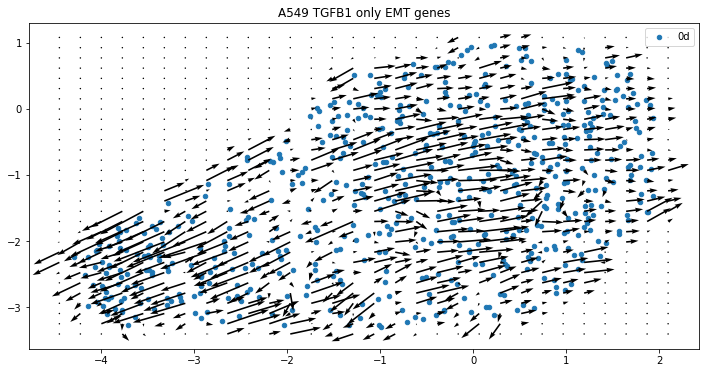

In [7]:
plot_X(X_emb, create_figure=True, figsize=(12, 6),s=20,label='0d')

plt.legend()

plt.title('A549 TGFB1 only EMT genes')

plot_V(X_grid, U_grid, facecolor='k')

/home/dap182/anaconda3/envs/kb/lib/python3.7/site-packages/anndata/_core/anndata.py:1342: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning,


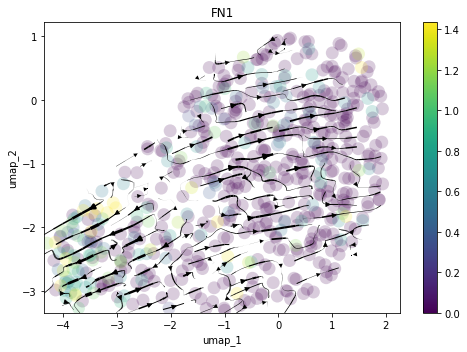

In [6]:
dyn.pl.streamline_plot(adata,basis='umap',color='FN1')